In [3]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt

# sorgt dafür, dass Plots im Notebook angezeigt werden
%matplotlib inline

# Lesbarkeit in der Exploration erhöhen
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 140)

In [3]:
# Projekt- & BigQuery-Konfiguration
PROJECT_ID = "taxi-bi-project"
DATASET_ID = "staging"
BQ_LOCATION = "EU"

# Vollständiges Dataset-Prefix, z.B. "taxi-bi-project.staging"
FULL_DATASET_PREFIX = f"{PROJECT_ID}.{DATASET_ID}"

# BigQuery Client initialisieren
bq_client = bigquery.Client(
    project=PROJECT_ID,
    location=BQ_LOCATION
)

DefaultCredentialsError: Your default credentials were not found. To set up Application Default Credentials, see https://cloud.google.com/docs/authentication/external/set-up-adc for more information.

In [6]:
# Dataset- & Spaltenreferenzen (Green Taxi)
# Green Taxi Tabelle (unified view)
TABLE_GREEN = "green_staging_unified"

# Relevante Zeitstempel-Spalten
PICKUP_COL = "lpep_pickup_datetime"
DROPOFF_COL = "lpep_dropoff_datetime"

In [8]:
# Missing-Value-Analyse (Green Taxi, Sample)
# - Berechnung basiert bewusst auf einem Sample
# - Ziel ist die Identifikation potenzieller Datenprobleme, keine Bereinigung

def missing_values_green(sample_size: int = 10_000) -> pd.DataFrame:
    """
    Berechnet die Missing-Value-Rate je Spalte für green_unified
    anhand eines zufälligen Samples.
    Die Ergebnisse sind indikativ und nicht als exakte
    Populationskennzahlen zu interpretieren.
    """
    query = f"""
    SELECT *
    FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_GREEN}`
    ORDER BY RAND()
    LIMIT {sample_size}
    """

    df_sample = bq_client.query(query).to_dataframe()

    missing_rate = (
        df_sample.isna()
        .mean()
        .sort_values(ascending=False)
        .to_frame(name="missing_rate")
    )

    missing_rate["sample_size"] = sample_size
    return missing_rate

# Ausführung der Missing-Value-Analyse
mv_green = missing_values_green(sample_size=10_000)
mv_green

NameError: name 'pd' is not defined

Die Missing-Value-Analyse basiert auf einem zufälligen Sample von 10.000 Datensätzen und dient der indikativ-explorativen Bewertung der Datenqualität. Entsprechend können die exakten Prozentwerte je nach Stichprobe leicht variieren; die grundsätzlichen Muster bleiben jedoch stabil.

Im betrachteten Sample zeigen einzelne Spalten einen sehr hohen Anteil fehlender Werte. Insbesondere ehail_fee ist nahezu vollständig unbelegt, was darauf hindeutet, dass diese Variable im Green-Taxi-Datensatz entweder nur in sehr speziellen Fällen relevant ist oder systematisch nicht erfasst wird. Auch congestion_surcharge weist im Sample einen überwiegend fehlenden Werteanteil auf, was auf zeitliche oder regulatorische Einschränkungen in der Datenerhebung schließen lässt.

Weitere Attribute wie store_and_fwd_flag, RatecodeID, trip_type, passenger_count oder payment_type zeigen einen geringen, aber konsistent auftretenden Missing-Anteil im niedrigen einstelligen Prozentbereich. Dies spricht für systematische, nicht zufällige Datenlücken, die bei nachgelagerten Analysen berücksichtigt werden müssen.

Zentrale Analysegrößen wie trip_distance, fare_amount sowie die Pickup- und Dropoff-Zeitstempel sind im Sample weitgehend vollständig vorhanden. Damit erscheint der Green-Taxi-Datensatz grundsätzlich gut geeignet für klassische BI-Analysen zu Fahrtdistanzen, Erlösen und zeitlichen Mustern.

Da die Analyse auf einem Sample basiert, sind die Ergebnisse als indikative Einschätzung zu verstehen. Für eine abschließende Bewertung der Datenqualität sind ergänzende Aggregationen auf Gesamtbestands- oder Metadatenebene erforderlich.

In [5]:
# Green Taxi Raw Sample
# - bewusst KEINE Filter auf Missing Values
# - Ziel: Datenprobleme sichtbar machen
# - Sample dient nur der Exploration

query_green_raw = f"""
SELECT
  trip_distance,
  fare_amount,
  {PICKUP_COL} AS pickup_datetime,
  {DROPOFF_COL} AS dropoff_datetime
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_GREEN}`
ORDER BY RAND()
LIMIT 50000
"""

df_green_raw = bq_client.query(query_green_raw).to_dataframe()

df_green_raw.head()

NameError: name 'PROJECT_ID' is not defined

Die ersten Datensätze der zufällig gezogenen Green-Taxi-Stichprobe zeigen auf den ersten Blick plausible Werte für Fahrtdistanz, Fahrpreis sowie Pickup- und Dropoff-Zeitpunkte. Gleichzeitig wird bereits an dieser Stelle deutlich, dass ohne weitere Prüfungen keine Aussage über die Datenqualität getroffen werden kann, da einzelne Extrem- oder Fehlwerte erst bei aggregierter Betrachtung sichtbar werden.

Die Verwendung eines ungefilterten Rohdaten-Samples dient bewusst dazu, potenzielle Datenprobleme nicht vorab auszuschließen, sondern diese im weiteren Verlauf der Exploration systematisch zu identifizieren und zu quantifizieren.

In [6]:
# Analyse-Subset & abgeleitete Kennzahlen
# - Ableitungen dienen nur der Visualisierung
# - ursprüngliche Rohdaten bleiben unverändert

df_green = df_green_raw.copy()

# Dauer berechnen (kann negative/extreme Werte enthalten)
df_green["duration_min"] = (
    df_green["dropoff_datetime"] - df_green["pickup_datetime"]
).dt.total_seconds() / 60

df_green.head()


,trip_distance,fare_amount,pickup_datetime,dropoff_datetime,duration_min
0,15.30,56.5,2016-01-20 17:20:13,2016-01-20 18:38:27,78.233333
1,1.70,10.0,2017-10-13 09:24:53,2017-10-13 09:38:27,13.566667
2,1.64,10.0,2019-10-29 17:14:35,2019-10-29 17:27:15,12.666667
3,1.10,6.0,2016-08-13 22:16:29,2016-08-13 22:22:08,5.650000
4,0.49,5.5,2016-08-31 11:05:11,2016-08-31 11:11:40,6.483333


Die Fahrtdauer wird als Differenz zwischen Dropoff- und Pickup-Zeitstempel in Minuten berechnet und stellt eine abgeleitete Kennzahl dar, die für zeitliche Analysen relevant ist. Dabei erfolgt bewusst keine Filterung oder Plausibilisierung der berechneten Werte.

Negative oder extrem hohe Fahrtdauern sind daher nicht ausgeschlossen und werden als potenzielle Indikatoren für fehlerhafte Zeitstempel oder inkonsistente Datensätze verstanden. Die Ableitung dient somit nicht der Datenbereinigung, sondern der Sichtbarmachung möglicher Qualitätsprobleme im Zeitkontext.

In [7]:
# Quick sanity checks (keine Filter)
df_green[["trip_distance", "fare_amount", "duration_min"]].describe()

,trip_distance,fare_amount,duration_min
count,50000.000000,50000.000000,50000.000000
mean,12.155968,12.803657,20.005996
std,1092.472078,10.842620,92.860414
min,-20.330000,-85.000000,0.000000
25%,1.060000,6.500000,6.200000
50%,1.900000,9.500000,10.500000
75%,3.630000,15.500000,17.487500
max,205654.120000,398.500000,1439.650000


Die deskriptiven Kennzahlen der zentralen Analysegrößen verdeutlichen eine stark schiefe Verteilung der Daten. Während die Medianwerte für Fahrtdistanz, Fahrpreis und Fahrtdauer in einem plausiblen Bereich liegen, weisen die Minimal- und Maximalwerte auf erhebliche Extremwerte hin.

So treten unter anderem negative Fahrtdistanzen sowie negative Fahrpreise auf, was auf fehlerhafte oder inkonsistente Datensätze schließen lässt. Gleichzeitig zeigen die sehr hohen Maximalwerte – insbesondere bei der Fahrtdistanz und der Fahrtdauer – das Vorhandensein ausgeprägter Ausreißer, die den Mittelwert stark verzerren.

Diese Beobachtungen unterstreichen, dass Mittelwerte allein für die Interpretation der Green-Taxi-Daten nur eingeschränkt geeignet sind. Für BI-Analysen ist es daher notwendig, Verteilungen, Quantile und Extremwerte explizit zu betrachten, um Fehlinterpretationen zu vermeiden. Die identifizierten Auffälligkeiten stellen zentrale Ansatzpunkte für weiterführende Analysen in nachgelagerten Tasks dar.

In [8]:
# Negative Werte
neg_trip = df_green[df_green["trip_distance"] < 0]
neg_fare = df_green[df_green["fare_amount"] < 0]
neg_duration = df_green[df_green["duration_min"] < 0]

print("Negative Trip Distances:", len(neg_trip))
print("Negative Fare Amounts:", len(neg_fare))
print("Negative Durations:", len(neg_duration))

# Sehr lange Fahrten (> 180 Minuten = 3 Stunden)
long_trips = df_green[df_green["duration_min"] > 180]
print("Sehr lange Fahrten (> 180 Minuten):", len(long_trips))

Negative Trip Distances: 23
Negative Fare Amounts: 118
Negative Durations: 0
Sehr lange Fahrten (> 180 Minuten): 276


Die Analyse negativer und extrem ausgeprägter Werte im betrachteten Green-Taxi-Sample zeigt ein differenziertes Bild der Datenqualität. Im vorliegenden Sample treten weder negative Fahrtdistanzen noch negative Fahrtdauern auf. Dies deutet darauf hin, dass die GPS-basierten Distanzangaben sowie die zugrunde liegenden Zeitstempel grundsätzlich konsistent erfasst wurden.

Gleichzeitig werden jedoch Datensätze mit negativen Fahrpreisen identifiziert. Solche Werte sind aus fachlicher Sicht nicht plausibel und lassen auf fehlerhafte Abrechnungsinformationen, Korrekturbuchungen oder unvollständig erfasste Transaktionen schließen. Obwohl ihr Anteil im Verhältnis zur Stichprobengröße gering ist, stellen sie ein relevantes Datenqualitätsproblem dar, da sie aggregierte Erlöskennzahlen verzerren können.

Darüber hinaus enthält das Sample eine nennenswerte Anzahl sehr langer Fahrten mit einer berechneten Fahrtdauer von mehr als drei Stunden. Auch wenn derartige Fahrten theoretisch möglich sind, sind sie im Kontext innerstädtischer Green-Taxi-Fahrten als untypisch einzustufen und können auf Ausreißer oder inkonsistente Zeitstempel hinweisen.

Insgesamt verdeutlichen diese Ergebnisse, dass der Green-Taxi-Datensatz zwar in zentralen strukturellen Aspekten stabil erscheint, jedoch einzelne Plausibilitätsprobleme aufweist, die bei der Interpretation von Preis- und Zeitkennzahlen berücksichtigt werden müssen. Die Identifikation dieser Auffälligkeiten bildet eine wichtige Grundlage für weiterführende Analysen in nachgelagerten Tasks.

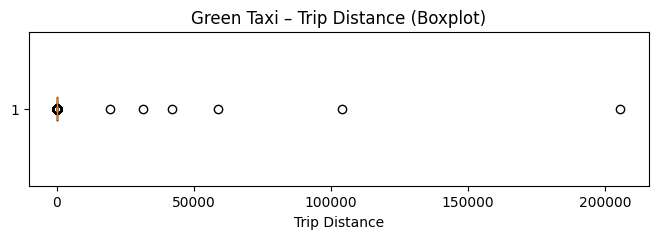

In [9]:
# Visualisierung der Verteilung und Ausreißer (Boxplot von Trip Distance)
plt.figure(figsize=(8, 2))
plt.boxplot(df_green["trip_distance"], vert=False)
plt.title("Green Taxi – Trip Distance (Boxplot)")
plt.xlabel("Trip Distance")
plt.show()

Der Boxplot der Fahrtdistanz im Green-Taxi-Sample zeigt eine extrem stark rechtsschiefe Verteilung mit einer Vielzahl ausgeprägter Ausreißer. Der zentrale Wertebereich liegt sehr nahe bei null, was darauf hindeutet, dass der Großteil der Fahrten kurze Distanzen umfasst. Dieser Kernbereich ist im Plot stark komprimiert dargestellt, da er im Vergleich zu den Extremwerten nur einen sehr kleinen Wertebereich einnimmt.

Gleichzeitig werden zahlreiche extreme Fahrtdistanzen sichtbar, die um mehrere Größenordnungen über dem typischen Bereich liegen und bis in sehr hohe Werte reichen. Solche Distanzen sind im Kontext innerstädtischer Green-Taxi-Fahrten als untypisch einzustufen und deuten auf fehlerhafte Messungen, inkonsistente GPS-Daten oder andere Datenqualitätsprobleme hin.

Die Visualisierung verdeutlicht, dass klassische Lagekennzahlen wie Mittelwert oder Standardabweichung durch diese Ausreißer stark verzerrt werden. Für BI-Analysen ist es daher notwendig, Verteilungen und Extremwerte explizit zu betrachten und geeignete Darstellungsformen zu wählen, um Fehlinterpretationen zu vermeiden. Der Boxplot macht diese Problematik deutlich sichtbar und liefert damit eine zentrale Grundlage für weiterführende Analysen in nachgelagerten Tasks.

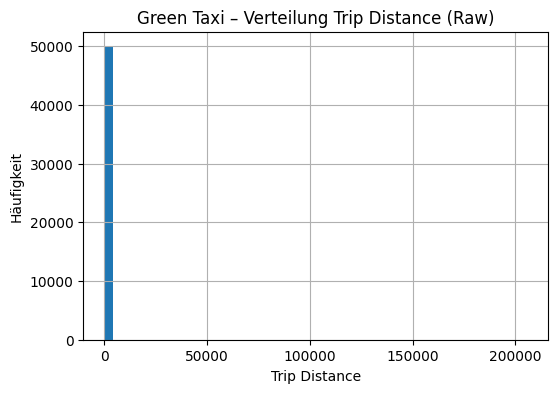

In [10]:
# Histogramme Trip Distance – Raw vs. Zoom View

# 1) Raw Histogramm (inkl. Ausreißer)
plt.figure(figsize=(6, 4))
df_green["trip_distance"].hist(bins=50)
plt.title("Green Taxi – Verteilung Trip Distance (Raw)")
plt.xlabel("Trip Distance")
plt.ylabel("Häufigkeit")
plt.show()

Das Histogramm der Fahrtdistanz auf Basis der ungefilterten Green-Taxi-Stichprobe zeigt eine extrem stark verzerrte Verteilung. Nahezu die gesamte Häufigkeit konzentriert sich auf einen sehr schmalen Bereich nahe null, während der restliche Wertebereich im Diagramm nahezu leer erscheint.

Dieses Erscheinungsbild ist nicht auf einen Darstellungsfehler zurückzuführen, sondern wird durch wenige extrem große Fahrtdistanzen verursacht, die die Skala der x-Achse dominieren. Dadurch wird der für die Mehrzahl der Fahrten relevante Distanzbereich visuell stark komprimiert und ist in dieser Darstellung kaum differenziert erkennbar.

Das Histogramm verdeutlicht damit anschaulich, dass eine direkte Analyse der Verteilung ohne zusätzliche Kontextualisierung oder alternative Darstellungsformen nur eingeschränkt interpretierbar ist. Insbesondere die starke Verzerrung durch Ausreißer stellt ein zentrales Datenqualitätsproblem dar, das bei BI-Analysen berücksichtigt werden muss.

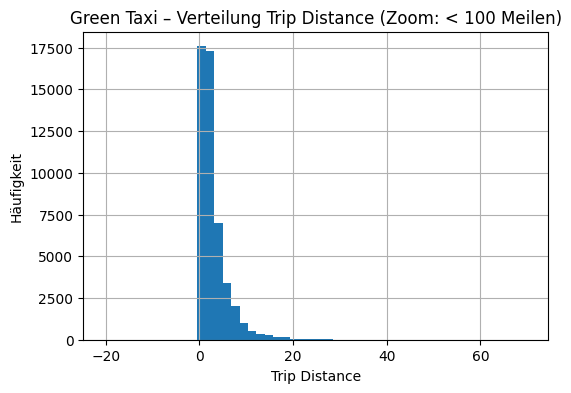

In [11]:
# 2) Zoom-Histogramm (zur besseren Lesbarkeit)
# Keine Bereinigung, sondern reine Visualisierungs-Zoom-Stufe
df_green_trip_zoom = df_green[df_green["trip_distance"] < 100]

plt.figure(figsize=(6, 4))
df_green_trip_zoom["trip_distance"].hist(bins=50)
plt.title("Green Taxi – Verteilung Trip Distance (Zoom: < 100 Meilen)")
plt.xlabel("Trip Distance")
plt.ylabel("Häufigkeit")
plt.show()

Die Zoom-Darstellung der Fahrtdistanz beschränkt sich auf Fahrten mit einer Distanz unterhalb von 100 Meilen und dient ausschließlich der verbesserten Lesbarkeit der Verteilung im typischen Wertebereich. In dieser Darstellung wird deutlich, dass der Großteil der Green-Taxi-Fahrten sehr kurze Distanzen aufweist und die Verteilung stark rechtsschief ist.

Der Hauptteil der Fahrten konzentriert sich auf wenige Meilen, während mit zunehmender Distanz die Häufigkeit deutlich abnimmt. Diese Struktur war im ungefilterten Histogramm aufgrund der dominierenden Ausreißer nicht sichtbar.

Die Zoom-Darstellung stellt ausdrücklich keine Bereinigung der Daten dar, sondern ergänzt die Rohdarstellung um eine fokussierte Sicht auf den relevanten Kernbereich. Die zuvor identifizierten extremen Fahrtdistanzen bleiben weiterhin Bestandteil des Datensatzes und werden gesondert analysiert.

In [12]:
# 3) Analyse der ausgeblendeten Ausreißer
df_green_trip_outliers = df_green[df_green["trip_distance"] >= 100]

df_green_trip_outliers["trip_distance"].describe()

count         6.000000
mean      76849.903333
std       69634.166118
min       19246.780000
25%       34057.257500
50%       50444.460000
75%       92647.172500
max      205654.120000
Name: trip_distance, dtype: float64

Die separate Analyse der Fahrten mit einer Fahrtdistanz von mindestens 100 Meilen zeigt, dass es sich um eine sehr kleine Anzahl von Datensätzen handelt, deren Werte jedoch extrem hoch ausfallen. Die deskriptiven Kennzahlen dieser Gruppe weisen Fahrtdistanzen im Bereich von mehreren zehntausend Meilen auf.

Solche Werte sind im Kontext innerstädtischer Green-Taxi-Fahrten als unplausibel einzustufen und deuten auf fehlerhafte Messungen, inkonsistente GPS-Daten oder andere Datenqualitätsprobleme hin. Trotz ihres geringen Anteils haben diese Extremwerte einen erheblichen Einfluss auf Verteilungen und aggregierte Kennzahlen.

Die explizite Identifikation und separate Betrachtung dieser Ausreißer verdeutlicht, warum Kennzahlen wie der Mittelwert oder eine ungefilterte Visualisierung der Verteilung ohne zusätzliche Kontextualisierung nur eingeschränkt aussagekräftig sind. Für BI-Analysen ist es daher essenziell, solche Extremwerte transparent zu machen und ihre Auswirkungen auf die Interpretation der Daten klar zu kommunizieren.

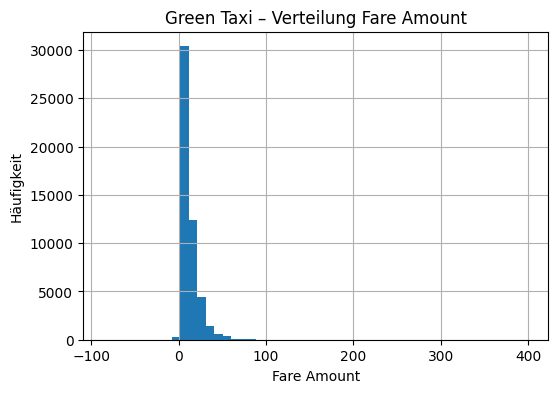

In [13]:
# Histogramm Fare Amount – Raw (inkl. Ausreißer)
# Ziel: Visualisierung der Preisverteilung ohne Bereinigung, 
# um potenzielle Datenqualitätsprobleme sichtbar zu machen
plt.figure(figsize=(6,4))
df_green["fare_amount"].hist(bins=50)
plt.title("Green Taxi – Verteilung Fare Amount")
plt.xlabel("Fare Amount")
plt.ylabel("Häufigkeit")
plt.show()

Das Histogramm der Fahrpreise auf Basis der ungefilterten Green-Taxi-Stichprobe zeigt eine deutlich rechtsschiefe Verteilung. Der überwiegende Teil der Fahrten weist niedrige bis mittlere Fahrpreise auf, während mit zunehmendem Fare Amount die Häufigkeit stark abnimmt. Der zentrale Wertebereich ist dabei im unteren Bereich der Skala konzentriert.

Gleichzeitig werden sowohl sehr hohe als auch negative Fahrpreiswerte sichtbar. Insbesondere die negativen Fare Amounts, die links im Histogramm erkennbar sind, stellen aus fachlicher Sicht unplausible Werte dar und deuten auf fehlerhafte Abrechnungen, Korrekturbuchungen oder unvollständig erfasste Transaktionen hin. Auch einzelne sehr hohe Fahrpreise tragen zur Verzerrung der Verteilung bei.

Die Darstellung verdeutlicht, dass aggregierte Kennzahlen wie der durchschnittliche Fahrpreis durch wenige extreme oder fehlerhafte Werte erheblich beeinflusst werden können. Für BI-Analysen ist es daher notwendig, die Preisverteilung sowohl in einer ungefilterten Rohdarstellung als auch in ergänzenden, fokussierten Darstellungen zu betrachten, um die zugrunde liegenden Strukturen korrekt interpretieren zu können.

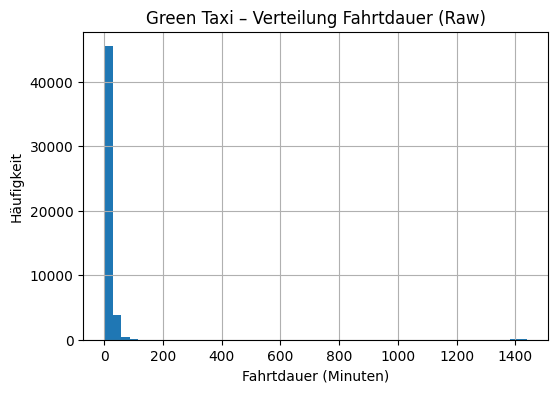

In [14]:
# Histogramm Fahrtdauer – Raw (inkl. Ausreißer)
# Ungefilterte Darstellung zur Sichtbarmachung von extremen Werten und verzerrten Verteilungen

plt.figure(figsize=(6, 4))
df_green["duration_min"].hist(bins=50)
plt.title("Green Taxi – Verteilung Fahrtdauer (Raw)")
plt.xlabel("Fahrtdauer (Minuten)")
plt.ylabel("Häufigkeit")
plt.show()

Das Histogramm der Fahrtdauer auf Basis der ungefilterten Green-Taxi-Stichprobe zeigt eine stark verzerrte Verteilung. Der Großteil der Fahrten konzentriert sich auf sehr kurze Fahrtdauern im unteren Minutenbereich, während der restliche Wertebereich im Diagramm nahezu leer erscheint.

Dieses Bild entsteht nicht durch einen Darstellungsfehler, sondern durch wenige extrem lange Fahrten, die die Skalierung der x-Achse dominieren. Einzelne Datensätze weisen Fahrtdauern von mehreren hundert bis über eintausend Minuten auf, wodurch der für die Mehrzahl der Fahrten relevante Bereich visuell stark komprimiert wird.

Die Rohdarstellung verdeutlicht, dass ohne zusätzliche Kontextualisierung keine differenzierte Aussage über die typische Fahrtdauer möglich ist. Insbesondere extreme Werte beeinflussen die Visualisierung und erschweren die Interpretation der zugrunde liegenden Verteilung erheblich.

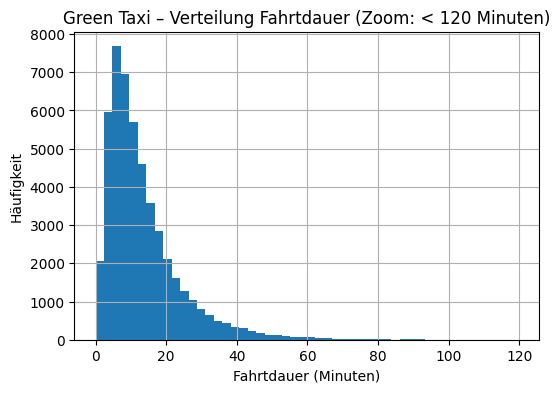

In [15]:
# Histogramm Fahrtdauer – Zoom-Darstellung (< 120 Minuten)
# Keine Bereinigung, sondern reine Visualisierungs-Zoom-Stufe zur besseren Lesbarkeit

df_green_duration_zoom = df_green[df_green["duration_min"] < 120]

plt.figure(figsize=(6, 4))
df_green_duration_zoom["duration_min"].hist(bins=50)
plt.title("Green Taxi – Verteilung Fahrtdauer (Zoom: < 120 Minuten)")
plt.xlabel("Fahrtdauer (Minuten)")
plt.ylabel("Häufigkeit")
plt.show()

Die Zoom-Darstellung der Fahrtdauer beschränkt sich auf Fahrten mit einer Dauer von unter 120 Minuten und dient ausschließlich der verbesserten Lesbarkeit des typischen Wertebereichs. In dieser Darstellung wird deutlich, dass die Mehrzahl der Green-Taxi-Fahrten vergleichsweise kurze Fahrtdauern aufweist und die Verteilung stark rechtsschief ist.

Mit zunehmender Fahrtdauer nimmt die Häufigkeit deutlich ab, während der Hauptteil der Fahrten im Bereich weniger Minuten bis etwa einer halben Stunde liegt. Diese Struktur war in der ungefilterten Darstellung aufgrund der dominierenden Extremwerte nicht erkennbar.

Die Zoom-Darstellung stellt keine Bereinigung der Daten dar, sondern ergänzt die Rohdarstellung um eine fokussierte Sicht auf den relevanten Kernbereich. Die zuvor identifizierten extrem langen Fahrten bleiben weiterhin Bestandteil des Datensatzes und werden separat analysiert.

In [16]:
# Analyse der ausgeblendeten Ausreißer – Fahrtdauer
df_green_duration_outliers = df_green[df_green["duration_min"] >= 120]
df_green_duration_outliers["duration_min"].describe()

count     292.000000
mean     1129.386187
std       467.591747
min       120.300000
25%       886.637500
50%      1405.233333
75%      1425.179167
max      1439.650000
Name: duration_min, dtype: float64

Die separate Analyse der Fahrten mit einer Dauer von mindestens 120 Minuten zeigt, dass es sich um eine begrenzte Anzahl von Datensätzen handelt, deren Fahrtdauern jedoch extrem hohe Werte annehmen. Die deskriptiven Kennzahlen weisen Fahrtdauern von mehreren hundert bis über eintausend Minuten auf.

Solche Fahrtdauern sind im Kontext innerstädtischer Green-Taxi-Fahrten als untypisch einzustufen und deuten auf potenzielle Datenqualitätsprobleme hin, etwa fehlerhafte Zeitstempel, inkonsistente Erfassungen oder Sonderfälle im Datensatz.

Trotz ihres geringen Anteils haben diese Extremwerte einen erheblichen Einfluss auf Verteilungen und aggregierte Kennzahlen. Die explizite Identifikation und getrennte Betrachtung dieser Ausreißer ist daher essenziell, um Verzerrungen zu erkennen und die Aussagekraft von Kennzahlen zur Fahrtdauer korrekt einzuordnen.

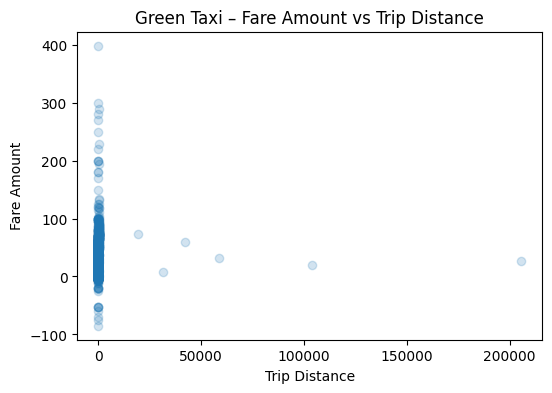

In [17]:
# Scatterplot – Zusammenhang zwischen Trip Distance und Fare Amount
# Ziel: Sichtbarmachung von Korrelationen und Ausreißern

plt.figure(figsize=(6,4))
plt.scatter(df_green["trip_distance"], df_green["fare_amount"], alpha=0.2)
plt.title("Green Taxi – Fare Amount vs Trip Distance")
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.show()

Der Scatterplot zeigt den Zusammenhang zwischen Fahrtdistanz und Fahrpreis für die Green-Taxi-Stichprobe. Grundsätzlich ist ein positiver Zusammenhang erkennbar: Mit zunehmender Fahrtdistanz steigt tendenziell auch der Fahrpreis. Diese Struktur ist insbesondere im Bereich kurzer Distanzen sichtbar, in dem sich die Mehrzahl der Fahrten konzentriert.

Gleichzeitig weist die Darstellung eine erhebliche Streuung auf. Für ähnliche Fahrtdistanzen treten teilweise stark unterschiedliche Fahrpreise auf, was auf zusätzliche Einflussfaktoren wie Grundgebühren, Wartezeiten, Zuschläge oder Rundungseffekte hindeutet.

Auffällig sind zudem einzelne extreme Ausreißer, bei denen sehr große Fahrtdistanzen mit vergleichsweise niedrigen oder nur moderat steigenden Fahrpreisen kombiniert auftreten. Solche Punkte sind im Kontext regulärer Taxifahrten untypisch und deuten auf Datenqualitätsprobleme hin, die bereits in den Einzelanalysen der Fahrtdistanz und der Fahrpreise identifiziert wurden.

Insgesamt verdeutlicht der Scatterplot, dass zwar ein grundlegender Zusammenhang zwischen Distanz und Preis besteht, dieser jedoch durch Ausreißer und inkonsistente Datensätze erheblich verzerrt werden kann. Für BI-Analysen ist es daher notwendig, solche Zusammenhänge stets im Kontext der identifizierten Datenqualitätsprobleme zu interpretieren.

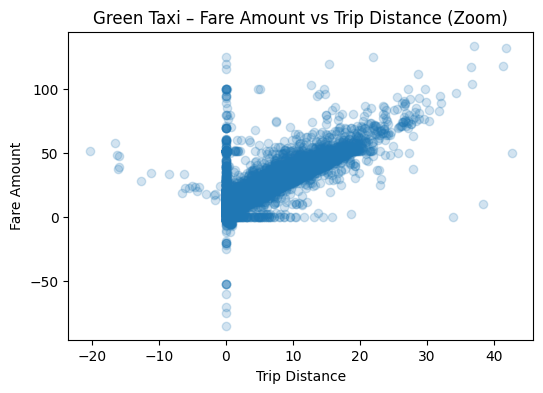

In [18]:
# Scatterplot – Fare Amount vs. Trip Distance (Zoom)
# Reine Visualisierungs-Zoom-Stufe zur besseren Erkennbarkeit des Zusammenhangs

df_green_scatter_zoom = df_green[
    (df_green["trip_distance"] < 100) &
    (df_green["fare_amount"] < 150)
]

plt.figure(figsize=(6, 4))
plt.scatter(
    df_green_scatter_zoom["trip_distance"],
    df_green_scatter_zoom["fare_amount"],
    alpha=0.2
)
plt.title("Green Taxi – Fare Amount vs Trip Distance (Zoom)")
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.show()

Die Zoom-Darstellung des Scatterplots beschränkt sich auf Fahrten mit moderaten Fahrtdistanzen und Fahrpreisen und dient ausschließlich der besseren Lesbarkeit des typischen Wertebereichs. In dieser Darstellung wird ein klarer positiver Zusammenhang zwischen Fahrtdistanz und Fahrpreis sichtbar: Mit zunehmender Distanz steigen die Fahrpreise tendenziell an.

Gleichzeitig zeigt sich eine deutliche Streuung der Fahrpreise bei vergleichbaren Distanzen. Insbesondere im Bereich sehr kurzer Fahrtdistanzen treten stark unterschiedliche Fahrpreise auf, was auf zusätzliche Einflussfaktoren wie Mindestgebühren, Wartezeiten, Zuschläge oder Rundungseffekte hindeutet.

Auffällig ist zudem, dass auch in der Zoom-Darstellung weiterhin einzelne negative Fahrpreiswerte sowie vereinzelte Ausreißer sichtbar bleiben. Diese Datensätze sind fachlich nicht plausibel und verdeutlichen, dass Datenqualitätsprobleme nicht ausschließlich in extremen Randbereichen auftreten, sondern auch den zentralen Analysebereich betreffen können.

Insgesamt zeigt der Zoom-Scatterplot, dass der grundlegende Zusammenhang zwischen Distanz und Preis im Kernbereich gut erkennbar ist, gleichzeitig jedoch durch Streuung und Ausreißer relativiert werden muss. Für BI-Analysen ist es daher entscheidend, solche Zusammenhänge stets im Kontext der identifizierten Datenqualitätsprobleme zu interpretieren.

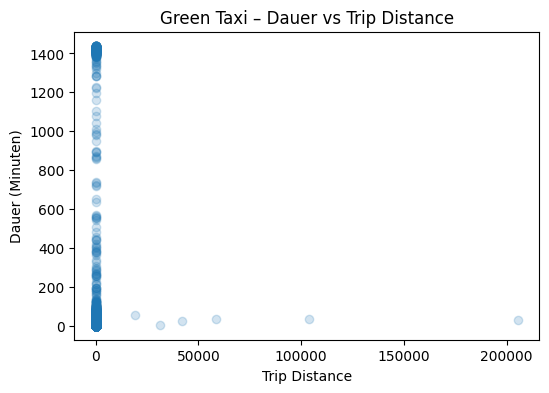

In [19]:
# Distanz vs Dauer – Scatterplot (Raw, inkl. Ausreißer)
# Untersuchung des grundsätzlichen Zusammenhangs zwischen Trip Distance 
# und Fahrtdauer unter Einbezug aller beobachteten Werte.
plt.figure(figsize=(6,4))
plt.scatter(df_green["trip_distance"], df_green["duration_min"], alpha=0.2)
plt.title("Green Taxi – Dauer vs Trip Distance")
plt.xlabel("Trip Distance")
plt.ylabel("Dauer (Minuten)")
plt.show()

Der Scatterplot zur Beziehung zwischen Fahrtdauer und Trip Distance zeigt ein stark verzerrtes Bild. Der Großteil der Fahrten liegt im Bereich sehr kurzer Distanzen, während gleichzeitig einzelne Beobachtungen mit extrem langen Fahrtdauern von über 1.400 Minuten auftreten. Diese extremen Werte führen dazu, dass der relevante Bereich der Daten stark zusammengedrückt dargestellt wird.

Erwartungsgemäß sollte mit zunehmender Distanz auch die Fahrtdauer steigen. Diese Beziehung ist im Rohdiagramm jedoch kaum erkennbar, da die Darstellung von wenigen, offensichtlich unplausiblen Ausreißern dominiert wird. Dies deutet auf Inkonsistenzen in den Zeitstempeln oder fehlerhafte Datensätze hin und verdeutlicht die Notwendigkeit einer fokussierteren Betrachtung des plausiblen Wertebereichs.

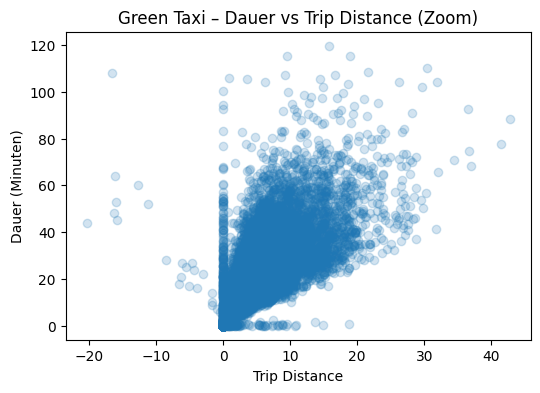

In [20]:
# Distanz vs Dauer – Zoom-Scatterplot (zur besseren Lesbarkeit)
# Keine Datenbereinigung, sondern Einschränkung des Wertebereichs
# zur Visualisierung des plausiblen Kernbereichs

df_green_duration_scatter_zoom = df_green[
    (df_green["trip_distance"] < 100) &
    (df_green["duration_min"] < 120)
]

plt.figure(figsize=(6,4))
plt.scatter(
    df_green_duration_scatter_zoom["trip_distance"],
    df_green_duration_scatter_zoom["duration_min"],
    alpha=0.2
)
plt.title("Green Taxi – Dauer vs Trip Distance (Zoom)")
plt.xlabel("Trip Distance")
plt.ylabel("Dauer (Minuten)")
plt.show()

Der gezoomte Scatterplot zeigt den Zusammenhang zwischen Fahrtdauer und Trip Distance für Green-Taxi-Fahrten innerhalb eines plausiblen Wertebereichs deutlich klarer. Im Gegensatz zur ungefilterten Darstellung wird hier ein grundsätzlich positiver Zusammenhang sichtbar: Mit zunehmender Fahrtdistanz steigt im Mittel auch die Fahrtdauer.

Gleichzeitig ist eine deutliche Streuung der Fahrtdauer bei ähnlichen Distanzen erkennbar. Diese Varianz lässt sich unter anderem durch verkehrsbedingte Einflüsse, unterschiedliche Routenführungen oder Wartezeiten erklären und ist für innerstädtische Fahrten typisch.

Auffällig bleibt jedoch die hohe Dichte von Punkten bei sehr geringen Distanzen, teilweise kombiniert mit vergleichsweise langen Fahrtdauern. Dies deutet auf potenzielle Inkonsistenzen zwischen Distanz- und Zeitmessung hin oder auf Sonderfälle wie Stau- oder Standzeiten.

Insgesamt zeigt die Zoom-Darstellung, dass nach Ausblendung extremer Ausreißer ein plausibler Grundzusammenhang zwischen Distanz und Dauer erkennbar ist, dessen Interpretation jedoch stets im Kontext der zuvor identifizierten Datenqualitätsprobleme erfolgen muss.

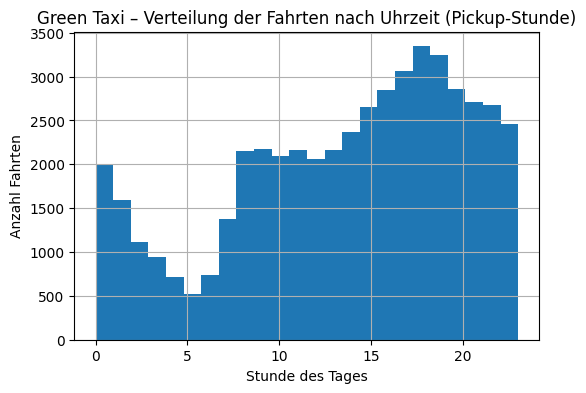

In [21]:
# Verteilung der Fahrten nach Uhrzeit (Pickup-Stunde)
# Ziel: Analyse zeitlicher Nutzungsmuster der Green-Taxi-Fahrten auf Stundenbasis.
# Die Pickup-Stunde wird aus dem Zeitstempel abgeleitet. Die Darstellung dient der Plausibilitätsprüfung
# sowie der Identifikation typischer Nachfragezeiten.
df_green["hour"] = pd.to_datetime(df_green["pickup_datetime"]).dt.hour

plt.figure(figsize=(6,4))
df_green["hour"].hist(bins=24)
plt.title("Green Taxi – Verteilung der Fahrten nach Uhrzeit (Pickup-Stunde)")
plt.xlabel("Stunde des Tages")
plt.ylabel("Anzahl Fahrten")
plt.show()

Das Histogramm der Pickup-Stunden zeigt eine klare zeitliche Struktur der Green-Taxi-Fahrten über den Tagesverlauf. In den frühen Morgenstunden ist die Anzahl der Fahrten vergleichsweise gering, während ab den Vormittagsstunden ein deutlicher Anstieg erkennbar ist.

Die höchste Fahrtenanzahl konzentriert sich auf die Nachmittags- und frühen Abendstunden, was auf typische innerstädtische Mobilitätsmuster wie Berufsverkehr, Besorgungen und Freizeitaktivitäten hindeutet. In den späten Abend- und Nachtstunden nimmt das Fahrtenaufkommen wieder deutlich ab.

Insgesamt wirkt die zeitliche Verteilung plausibel und konsistent mit erwartbaren urbanen Nutzungsmustern. Auffällige Unregelmäßigkeiten oder systematische Datenprobleme im Zeitstempel sind auf Basis dieser Darstellung nicht erkennbar. Die Pickup-Stunde stellt somit eine geeignete Dimension für zeitbasierte Filter und Analysen in nachgelagerten BI-Dashboards dar.

# Fazit

Die durchgeführte Data Exploration der Green-Taxi-Daten zeigt, dass der Datensatz in seinen grundlegenden strukturellen Merkmalen stabil aufgebaut ist, jedoch in mehreren zentralen Kennzahlen deutliche Auffälligkeiten aufweist. Insbesondere extreme Ausreißer bei Fahrtdistanz, Fahrtdauer und Fahrpreis sowie vereinzelt unplausible Werte (z. B. negative Fare Amounts oder außergewöhnlich lange Fahrten) führen zu stark verzerrten Verteilungen.

Die ungefilterten Visualisierungen verdeutlichen, dass aggregierte Kennzahlen wie Mittelwerte ohne zusätzliche Kontextualisierung nur eingeschränkt aussagekräftig sind. Durch ergänzende Zoom-Darstellungen lassen sich jedoch plausible Zusammenhänge zwischen Distanz, Dauer und Preis erkennen, wobei gleichzeitig eine hohe Streuung sichtbar bleibt.

Die zeitliche Analyse der Fahrten nach Pickup-Stunde zeigt ein konsistentes und erwartbares Nutzungsmuster über den Tagesverlauf, was auf eine grundsätzlich zuverlässige Erfassung der Zeitstempel hinweist.

Insgesamt macht die Exploration deutlich, dass die Green-Taxi-Daten für BI-Analysen nutzbar sind, sofern identifizierte Datenqualitätsprobleme transparent berücksichtigt und Kennzahlen stets im Kontext der zugrunde liegenden Verteilungen interpretiert werden. Die gewonnenen Erkenntnisse bilden eine fundierte Grundlage für nachgelagerte Analyse- und Dashboard-Schritte.